In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from ecgdetectors import Detectors
from scipy.signal import find_peaks
import pyeeg

In [3]:
df = pd.read_csv("E:/Thesis/Data/Hasil Identifikasi/sz6 post_ictal.txt")
df.head()

,Unnamed: 0,ECG,second,time
0,627800,2.7,3139.000,00:52:19
1,627801,3.0,3139.005,00:52:19
2,627802,2.2,3139.010,00:52:19
3,627803,2.5,3139.015,00:52:19
4,627804,3.1,3139.020,00:52:19


In [5]:
df.tail()

,Unnamed: 0,ECG,second,time
72195,699995,2.9,3499.975,00:58:19
72196,699996,2.7,3499.980,00:58:19
72197,699997,1.7,3499.985,00:58:19
72198,699998,2.5,3499.990,00:58:19
72199,699999,2.9,3499.995,00:58:19


In [6]:
df["Unnamed: 0"]=pd.Series(np.arange(1,len(df)+1,1))
df.rename(columns = {'Unnamed: 0':'no.'}, inplace = True)
df.tail()

,no.,ECG,second,time
72195,72196,2.9,3499.975,00:58:19
72196,72197,2.7,3499.980,00:58:19
72197,72198,1.7,3499.985,00:58:19
72198,72199,2.5,3499.990,00:58:19
72199,72200,2.9,3499.995,00:58:19


In [7]:
#overlapping data
size = 4000      # 6 rows in a new data-frame
list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df),size-3000) if i <len(df)-3000]
list_of_dfs

[       no.  ECG    second      time
 0        1  2.7  3139.000  00:52:19
 1        2  3.0  3139.005  00:52:19
 2        3  2.2  3139.010  00:52:19
 3        4  2.5  3139.015  00:52:19
 4        5  3.1  3139.020  00:52:19
 ...    ...  ...       ...       ...
 3995  3996  1.9  3158.975  00:52:38
 3996  3997  2.0  3158.980  00:52:38
 3997  3998  2.8  3158.985  00:52:38
 3998  3999  2.2  3158.990  00:52:38
 3999  4000  1.9  3158.995  00:52:38
 
 [4000 rows x 4 columns],
        no.  ECG    second      time
 1000  1001  3.2  3144.000  00:52:24
 1001  1002  2.4  3144.005  00:52:24
 1002  1003  2.6  3144.010  00:52:24
 1003  1004  3.3  3144.015  00:52:24
 1004  1005  2.8  3144.020  00:52:24
 ...    ...  ...       ...       ...
 4995  4996  2.2  3163.975  00:52:43
 4996  4997  3.1  3163.980  00:52:43
 4997  4998  2.7  3163.985  00:52:43
 4998  4999  2.1  3163.990  00:52:43
 4999  5000  3.0  3163.995  00:52:43
 
 [4000 rows x 4 columns],
        no.  ECG    second      time
 2000  2001  2.2  3

In [8]:
for i in range(len(list_of_dfs)):
    # create the new columns and assign them to the correct dataframe in the list
    list_of_dfs[i]["df"] = i+1

<ipython-input-8-eecaa4b9637b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_dfs[i]["df"] = i+1
<ipython-input-8-eecaa4b9637b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_dfs[i]["df"] = i+1
<ipython-input-8-eecaa4b9637b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [9]:
data = pd.concat(list_of_dfs)
data.tail()

,no.,ECG,second,time,df
72195,72196,2.9,3499.975,00:58:19,70
72196,72197,2.7,3499.980,00:58:19,70
72197,72198,1.7,3499.985,00:58:19,70
72198,72199,2.5,3499.990,00:58:19,70
72199,72200,2.9,3499.995,00:58:19,70


In [10]:
data['no.'] = data.groupby(['df']).cumcount()+1
data = data.reset_index()
data = data.drop(['index'], axis=1)
data[3995:4005]

,no.,ECG,second,time,df
3995,3996,1.9,3158.975,00:52:38,1
3996,3997,2.0,3158.980,00:52:38,1
3997,3998,2.8,3158.985,00:52:38,1
3998,3999,2.2,3158.990,00:52:38,1
3999,4000,1.9,3158.995,00:52:38,1
4000,1,3.2,3144.000,00:52:24,2
4001,2,2.4,3144.005,00:52:24,2
4002,3,2.6,3144.010,00:52:24,2
4003,4,3.3,3144.015,00:52:24,2
4004,5,2.8,3144.020,00:52:24,2


# Entropy

In [450]:
#create unique list of names
UniqueGroup = data.df.unique()
UniqueGroup

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueGroup}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.df == key]

In [451]:
DataFrameDict

{1:        no.  ECG    second      time  df
 0        1  2.7  3139.000  00:52:19   1
 1        2  3.0  3139.005  00:52:19   1
 2        3  2.2  3139.010  00:52:19   1
 3        4  2.5  3139.015  00:52:19   1
 4        5  3.1  3139.020  00:52:19   1
 ...    ...  ...       ...       ...  ..
 3995  3996  1.9  3158.975  00:52:38   1
 3996  3997  2.0  3158.980  00:52:38   1
 3997  3998  2.8  3158.985  00:52:38   1
 3998  3999  2.2  3158.990  00:52:38   1
 3999  4000  1.9  3158.995  00:52:38   1
 
 [4000 rows x 5 columns],
 2:        no.  ECG    second      time  df
 4000     1  3.2  3144.000  00:52:24   2
 4001     2  2.4  3144.005  00:52:24   2
 4002     3  2.6  3144.010  00:52:24   2
 4003     4  3.3  3144.015  00:52:24   2
 4004     5  2.8  3144.020  00:52:24   2
 ...    ...  ...       ...       ...  ..
 7995  3996  2.2  3163.975  00:52:43   2
 7996  3997  3.1  3163.980  00:52:43   2
 7997  3998  2.7  3163.985  00:52:43   2
 7998  3999  2.1  3163.990  00:52:43   2
 7999  4000  3.0  3163.

# ApEn

In [452]:
apen_df = []

for i in range(len(DataFrameDict)):
    apen = pyeeg.ap_entropy(DataFrameDict[i+1]['ECG'],3,0.2)
    print("%.16f" % apen)
    columns = {'apen':apen, 'group':i+1}
    apen_df.append(columns)

apen_df = pd.DataFrame(apen_df)

0.3723527974329922
0.3696560942511720
0.3737057298496058
0.3822454792074796
0.3913784943404131
0.3957287414121928
0.3915938072357490
0.3758206286143074
0.3647171677044229
0.3657147886107235
0.3707503930793628
0.3828426226230283
0.3825444850897268
0.3832376534123053
0.3730885068722325
0.3746046624653134
0.3833732300603370
0.3793356929128951
0.3950880581612799
0.3778471597610219
0.3862107839686691
0.3883844456320419
0.3845553229574554
0.3895509092961177
0.3774908893849949
0.3831733543396502
0.3840397731601702
0.3816818030447645
0.3826285869169624
0.3765433210349597
0.3696368407592635
0.3709926801194946
0.3726679048516084
0.3660085390251075
0.3791711471701165
0.3767487445320259
0.3768954254017395
0.4021817556116773
0.3964796071407750
0.3878856006149574
0.3781715410364793
0.3406529492671039
0.3406485946509294
0.3788885687315203
0.3839610540306966
0.3872733742871192
0.3868664445143467
0.3601241321128606
0.3655340639250748
0.3771065533013198
0.3849492787293904
0.3796528161121959
0.3871074921

# SampEn

In [453]:
sampen_df = []

for i in range(len(DataFrameDict)):
    sampen = pyeeg.samp_entropy(DataFrameDict[i+1]['ECG'],3,0.2)
    print("%.16f" % sampen)
    columns = {'sampen':sampen, 'group':i+1}
    sampen_df.append(columns)

sampen_df = pd.DataFrame(sampen_df)

0.3074905485021029
0.3095110899631705
0.3129993554464328
0.3274576996702275
0.3309340731006304
0.3332796953459935
0.3259210085722703
0.3099008570968763
0.3083507103206530
0.3088241757289223
0.3131603637518486
0.3286650780007760
0.3293037471426003
0.3206299066679472
0.3002735899973453
0.3003436837173483
0.3130217977857461
0.3125318730695850
0.3414157789916086
0.3131603814900930
0.3145497813602216
0.3225101981795542
0.3113045934890513
0.3225134856861879
0.3150712683623389
0.3239807608599220
0.3231623462666195
0.3297771716699628
0.3260045908692232
0.3241475903440076
0.3120827026121115
0.3074214165381284
0.3121763169024555
0.3027899436367325
0.3198239509220595
0.3261053518942078
0.3219912432950690
0.3432569600801468
0.3293818746875444
0.3136129164629163
0.3060427300586129
0.2785978496571093
0.2797135873317445
0.3072547157863456
0.3146789300601847
0.3204335377442249
0.3190186542239061
0.2977588432163988
0.3028493676739809
0.3211373767751795
0.3290203910398285
0.3247019594616415
0.3383315703

In [454]:
entropy = apen_df.merge(sampen_df, on='group', how='left')
entropy.tail()

,apen,group,sampen
65,0.376678,66,0.333367
66,0.377419,67,0.333861
67,0.385569,68,0.337500
68,0.392693,69,0.336474
69,0.383611,70,0.332629


# Time Domain Analysis

# R-Peak Detection

In [455]:
r_peak_list = []

for i in range(len(DataFrameDict)):
    peaks, _ = find_peaks(DataFrameDict[i+1]['ECG'], distance=140)
    np.diff(peaks)
    r_peak_list.append(peaks)

In [456]:
r_peak_data = []

for i in range(len(r_peak_list)):
    r_peak_df= pd.DataFrame(r_peak_list[i], columns = ['r_peaks'])
    r_peak_df['group'] = i+1
    r_peak_data.append(r_peak_df)
    
r_peak_df = pd.concat(r_peak_data)
r_peak_df

,r_peaks,group
0,47,1
1,227,1
2,410,1
3,590,1
4,774,1
...,...,...
14,2393,70
15,2569,70
16,2736,70
17,2909,70


In [457]:
r_peak_df["r_peak_second"] = r_peak_df["r_peaks"]*0.005
r_peak_df.tail()

,r_peaks,group,r_peak_second
14,2393,70,11.965
15,2569,70,12.845
16,2736,70,13.680
17,2909,70,14.545
18,3082,70,15.410


In [458]:
r_peak_df['RR_interval'] = r_peak_df['r_peak_second'].diff()
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval
0,47,1,0.235,NaN
1,227,1,1.135,0.900
2,410,1,2.050,0.915
3,590,1,2.950,0.900
4,774,1,3.870,0.920


In [459]:
r_peak_df['diff_group'] = r_peak_df['group'].diff()
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group
0,47,1,0.235,NaN,NaN
1,227,1,1.135,0.900,0.0
2,410,1,2.050,0.915,0.0
3,590,1,2.950,0.900,0.0
4,774,1,3.870,0.920,0.0


In [460]:
r_peak_df['RR_interval'] = r_peak_df['r_peak_second'].diff()
r_peak_df['RR_interval'].mask(r_peak_df['diff_group'] ==1, "", inplace=True)
r_peak_df['RR_interval'] = r_peak_df['RR_interval'].replace("", np.nan)
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group
0,47,1,0.235,NaN,NaN
1,227,1,1.135,0.900,0.0
2,410,1,2.050,0.915,0.0
3,590,1,2.950,0.900,0.0
4,774,1,3.870,0.920,0.0


# Mean

In [461]:
mean = r_peak_df.groupby(['group'])['RR_interval'].mean()
time_domain =  pd.DataFrame(mean).reset_index()
time_domain.rename(columns = {'RR_interval':'mean'}, inplace = True)
time_domain.head()

,group,mean
0,1,0.915714
1,2,0.910238
2,3,0.897045
3,4,0.862174
4,5,0.862045


# STD

In [462]:
std = r_peak_df.groupby(['group'])['RR_interval'].std()
std =  pd.DataFrame(std).reset_index()
time_domain["std"] = std['RR_interval']
time_domain

,group,mean,std
0,1,0.915714,0.025213
1,2,0.910238,0.030310
2,3,0.897045,0.034179
3,4,0.862174,0.055429
4,5,0.862045,0.036438
...,...,...,...
65,66,0.877955,0.022074
66,67,0.877273,0.021752
67,68,0.866591,0.021952
68,69,0.864318,0.023619


# Median

In [463]:
median = r_peak_df.groupby(['group'])['RR_interval'].median()
median =  pd.DataFrame(median).reset_index()
time_domain["median"] = median['RR_interval']
time_domain

,group,mean,std,median
0,1,0.915714,0.025213,0.9150
1,2,0.910238,0.030310,0.9100
2,3,0.897045,0.034179,0.9025
3,4,0.862174,0.055429,0.8700
4,5,0.862045,0.036438,0.8650
...,...,...,...,...
65,66,0.877955,0.022074,0.8800
66,67,0.877273,0.021752,0.8750
67,68,0.866591,0.021952,0.8650
68,69,0.864318,0.023619,0.8650


# IQR

In [464]:
q1 = r_peak_df.groupby(['group'])['RR_interval'].quantile(0.25)
q3 = r_peak_df.groupby(['group'])['RR_interval'].quantile(0.75)
iqr = q3-q1

iqr =  pd.DataFrame(iqr).reset_index()
time_domain["iqr"] = iqr['RR_interval']
time_domain.head()

,group,mean,std,median,iqr
0,1,0.915714,0.025213,0.9150,0.03000
1,2,0.910238,0.030310,0.9100,0.03000
2,3,0.897045,0.034179,0.9025,0.04875
3,4,0.862174,0.055429,0.8700,0.05250
4,5,0.862045,0.036438,0.8650,0.03375


# MAD

In [465]:
r_peak_df = r_peak_df.merge(time_domain, on='group', how='left')
r_peak_df['diff_rr_mean'] = abs(r_peak_df['RR_interval'] - r_peak_df['mean'])
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group,mean,std,median,iqr,diff_rr_mean
0,47,1,0.235,NaN,NaN,0.915714,0.025213,0.915,0.03,NaN
1,227,1,1.135,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714
2,410,1,2.050,0.915,0.0,0.915714,0.025213,0.915,0.03,0.000714
3,590,1,2.950,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714
4,774,1,3.870,0.920,0.0,0.915714,0.025213,0.915,0.03,0.004286


In [466]:
mad = r_peak_df.groupby(['group'])['diff_rr_mean'].mean()
mad =  pd.DataFrame(mad).reset_index()
time_domain["mad"] = mad['diff_rr_mean']
time_domain.head()

,group,mean,std,median,iqr,mad
0,1,0.915714,0.025213,0.9150,0.03000,0.018571
1,2,0.910238,0.030310,0.9100,0.03000,0.023107
2,3,0.897045,0.034179,0.9025,0.04875,0.027128
3,4,0.862174,0.055429,0.8700,0.05250,0.037410
4,5,0.862045,0.036438,0.8650,0.03375,0.027397


# NN50

In [467]:
r_peak_df['diff_RR_interval'] = r_peak_df['RR_interval'].diff()
r_peak_df['diff_RR_interval'] = r_peak_df['diff_RR_interval'].replace("", np.nan)
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group,mean,std,median,iqr,diff_rr_mean,diff_RR_interval
0,47,1,0.235,NaN,NaN,0.915714,0.025213,0.915,0.03,NaN,NaN
1,227,1,1.135,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,NaN
2,410,1,2.050,0.915,0.0,0.915714,0.025213,0.915,0.03,0.000714,0.015
3,590,1,2.950,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,-0.015
4,774,1,3.870,0.920,0.0,0.915714,0.025213,0.915,0.03,0.004286,0.020


In [468]:
r_peak_df['NN50'] = np.where(r_peak_df['diff_RR_interval']> 0.05, 1,0)
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group,mean,std,median,iqr,diff_rr_mean,diff_RR_interval,NN50
0,47,1,0.235,NaN,NaN,0.915714,0.025213,0.915,0.03,NaN,NaN,0
1,227,1,1.135,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,NaN,0
2,410,1,2.050,0.915,0.0,0.915714,0.025213,0.915,0.03,0.000714,0.015,0
3,590,1,2.950,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,-0.015,0
4,774,1,3.870,0.920,0.0,0.915714,0.025213,0.915,0.03,0.004286,0.020,0


In [469]:
NN50_count = r_peak_df.groupby(['group', 'NN50'])['r_peaks'].count()
NN50_count = pd.DataFrame(NN50_count).reset_index()
NN50_count

,group,NN50,r_peaks
0,1,0,21
1,1,1,1
2,2,0,21
3,2,1,1
4,3,0,23
...,...,...,...
110,68,1,1
111,69,0,22
112,69,1,1
113,70,0,18


In [470]:
NN50_var1 = NN50_count[NN50_count['NN50'] == 1]
NN50_var1

,group,NN50,r_peaks
1,1,1,1
3,2,1,1
6,4,1,1
8,5,1,1
10,6,1,1
12,7,1,2
14,8,1,2
16,9,1,1
18,10,1,1
20,11,1,2


In [471]:
NN50_var2 = NN50_count[NN50_count['NN50'] == 0]
NN50_var2['r_peaks'] = NN50_var2['r_peaks'] - 2
NN50_var2

<ipython-input-471-8ce4c027c4cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NN50_var2['r_peaks'] = NN50_var2['r_peaks'] - 2


,group,NN50,r_peaks
0,1,0,19
2,2,0,19
4,3,0,21
5,4,0,21
7,5,0,20
...,...,...,...
107,66,0,21
108,67,0,21
109,68,0,20
111,69,0,20


In [472]:
time_domain = time_domain.merge(NN50_var1, on='group', how='left')
time_domain = time_domain.merge(NN50_var2, on='group', how='left')
time_domain.rename(columns = {'r_peaks_x':'NN50_var1', 'r_peaks_y':'NN50_var2'}, inplace = True)
time_domain = time_domain.drop(['NN50_x', 'NN50_y'], axis=1)

time_domain['NN50_var1'] = time_domain['NN50_var1'].fillna(0)
time_domain['NN50_var2'] = time_domain['NN50_var2'].fillna(0)
time_domain

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20
...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20


# pNN50

In [473]:
RR_interval_count = r_peak_df.groupby(['group'])['r_peaks'].count()
RR_interval_count = pd.DataFrame(RR_interval_count).reset_index()
time_domain = time_domain.merge(RR_interval_count, on='group', how='left')
time_domain

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19,22
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19,22
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21,23
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21,24
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20,23
...,...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21,23
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21,23
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20,23
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20,23


In [474]:
time_domain['pNN50_var1'] = 100 * time_domain['NN50_var1']/time_domain['r_peaks']
time_domain['pNN50_var2'] = 100 * time_domain['NN50_var2']/time_domain['r_peaks']
time_domain

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks,pNN50_var1,pNN50_var2
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19,22,4.545455,86.363636
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19,22,4.545455,86.363636
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21,23,0.000000,91.304348
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21,24,4.166667,87.500000
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20,23,4.347826,86.956522
...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21,23,0.000000,91.304348
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21,23,0.000000,91.304348
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20,23,4.347826,86.956522
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20,23,4.347826,86.956522


# SDSD

In [475]:
sdsd = r_peak_df.groupby(['group'])['diff_RR_interval'].std()
sdsd =  pd.DataFrame(sdsd).reset_index()
time_domain["sdsd"] = sdsd['diff_RR_interval']
time_domain

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks,pNN50_var1,pNN50_var2,sdsd
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19,22,4.545455,86.363636,0.034702
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19,22,4.545455,86.363636,0.036284
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21,23,0.000000,91.304348,0.031642
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21,24,4.166667,87.500000,0.055086
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20,23,4.347826,86.956522,0.031523
...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21,23,0.000000,91.304348,0.023785
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21,23,0.000000,91.304348,0.024577
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20,23,4.347826,86.956522,0.024950
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20,23,4.347826,86.956522,0.027911


# RMSSD

In [476]:
r_peak_df['diff_RR_interval_square'] = r_peak_df['diff_RR_interval']**2
r_peak_df.head()

,r_peaks,group,r_peak_second,RR_interval,diff_group,mean,std,median,iqr,diff_rr_mean,diff_RR_interval,NN50,diff_RR_interval_square
0,47,1,0.235,NaN,NaN,0.915714,0.025213,0.915,0.03,NaN,NaN,0,NaN
1,227,1,1.135,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,NaN,0,NaN
2,410,1,2.050,0.915,0.0,0.915714,0.025213,0.915,0.03,0.000714,0.015,0,0.000225
3,590,1,2.950,0.900,0.0,0.915714,0.025213,0.915,0.03,0.015714,-0.015,0,0.000225
4,774,1,3.870,0.920,0.0,0.915714,0.025213,0.915,0.03,0.004286,0.020,0,0.000400


In [477]:
rmssd = r_peak_df.groupby(['group'])['diff_RR_interval_square'].mean()
rmssd =  pd.DataFrame(rmssd).reset_index()
rmssd['rmssd'] = rmssd['diff_RR_interval_square']**(1/2)
time_domain["rmssd"] = rmssd['rmssd']
time_domain

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks,pNN50_var1,pNN50_var2,sdsd,rmssd
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19,22,4.545455,86.363636,0.034702,0.033838
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19,22,4.545455,86.363636,0.036284,0.035408
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21,23,0.000000,91.304348,0.031642,0.030880
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21,24,4.166667,87.500000,0.055086,0.053820
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20,23,4.347826,86.956522,0.031523,0.030764
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21,23,0.000000,91.304348,0.023785,0.023223
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21,23,0.000000,91.304348,0.024577,0.024004
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20,23,4.347826,86.956522,0.024950,0.024349
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20,23,4.347826,86.956522,0.027911,0.027255


In [478]:
preprocessing = time_domain.merge(entropy, on='group', how='left')
preprocessing

,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks,pNN50_var1,pNN50_var2,sdsd,rmssd,apen,sampen
0,1,0.915714,0.025213,0.9150,0.03000,0.018571,1.0,19,22,4.545455,86.363636,0.034702,0.033838,0.372353,0.307491
1,2,0.910238,0.030310,0.9100,0.03000,0.023107,1.0,19,22,4.545455,86.363636,0.036284,0.035408,0.369656,0.309511
2,3,0.897045,0.034179,0.9025,0.04875,0.027128,0.0,21,23,0.000000,91.304348,0.031642,0.030880,0.373706,0.312999
3,4,0.862174,0.055429,0.8700,0.05250,0.037410,1.0,21,24,4.166667,87.500000,0.055086,0.053820,0.382245,0.327458
4,5,0.862045,0.036438,0.8650,0.03375,0.027397,1.0,20,23,4.347826,86.956522,0.031523,0.030764,0.391378,0.330934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.877955,0.022074,0.8800,0.02750,0.018140,0.0,21,23,0.000000,91.304348,0.023785,0.023223,0.376678,0.333367
66,67,0.877273,0.021752,0.8750,0.03375,0.018636,0.0,21,23,0.000000,91.304348,0.024577,0.024004,0.377419,0.333861
67,68,0.866591,0.021952,0.8650,0.02750,0.016260,1.0,20,23,4.347826,86.956522,0.024950,0.024349,0.385569,0.337500
68,69,0.864318,0.023619,0.8650,0.02625,0.017624,1.0,20,23,4.347826,86.956522,0.027911,0.027255,0.392693,0.336474


In [479]:
preprocessing["pasien"] = 6
preprocessing["class"] = 3
preprocessing.to_csv("E:/Thesis/Data/Hasil Preprocessing/3 Class_Overlap3000/sz6 post_ictal.csv")

In [377]:
df = pd.read_csv("E:/Thesis/Data/Hasil Identifikasi/sz2 normal.txt")
df.head()

,Unnamed: 0,ECG,second,time
0,0,1.08,0.000,00:00:00
1,1,1.08,0.005,00:00:00
2,2,1.12,0.010,00:00:00
3,3,1.12,0.015,00:00:00
4,4,1.08,0.020,00:00:00


In [378]:
ecg_ictal = df["ECG"]
n = len(ecg_ictal)
ecg_ictal = ecg_ictal.reset_index()
ecg_ictal = ecg_ictal["ECG"]

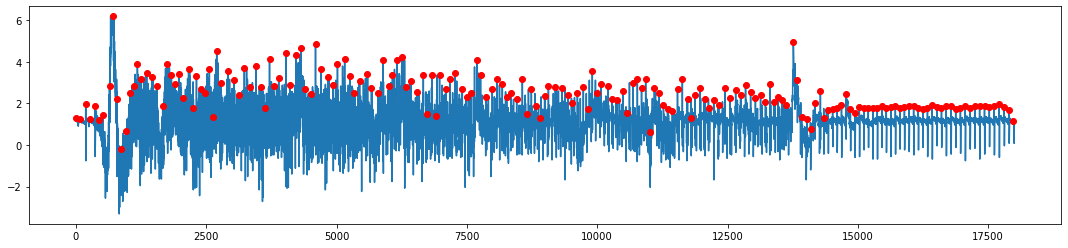

In [361]:
peaks, _ = find_peaks(ecg_ictal, distance=70)
np.diff(peaks)
plt.plot(ecg_ictal)
plt.plot(peaks, ecg_ictal[peaks], "ro")
fig = plt.gcf()
fig.set_size_inches(18.5, 4)

In [362]:
peaks

array([    6,    76,   189,   272,   366,   437,   516,   645,   717,
         788,   864,   954,  1036,  1110,  1180,  1252,  1358,  1465,
        1560,  1665,  1747,  1832,  1902,  1981,  2055,  2162,  2238,
        2313,  2401,  2475,  2560,  2630,  2701,  2780,  2917,  3036,
        3132,  3231,  3333,  3452,  3550,  3631,  3714,  3793,  3890,
        4029,  4102,  4226,  4322,  4404,  4504,  4596,  4703,  4836,
        4936,  5017,  5155,  5260,  5343,  5442,  5580,  5669,  5796,
        5889,  5999,  6072,  6164,  6254,  6338,  6432,  6545,  6664,
        6743,  6828,  6904,  6975,  7096,  7176,  7268,  7412,  7494,
        7578,  7689,  7761,  7862,  7986,  8072,  8179,  8263,  8346,
        8454,  8563,  8645,  8736,  8821,  8906,  8990,  9063,  9196,
        9320,  9441,  9523,  9619,  9733,  9823,  9905,  9987, 10075,
       10211, 10285, 10384, 10494, 10579, 10685, 10769, 10849, 10928,
       11014, 11095, 11188, 11270, 11348, 11439, 11539, 11632, 11731,
       11806, 11878,

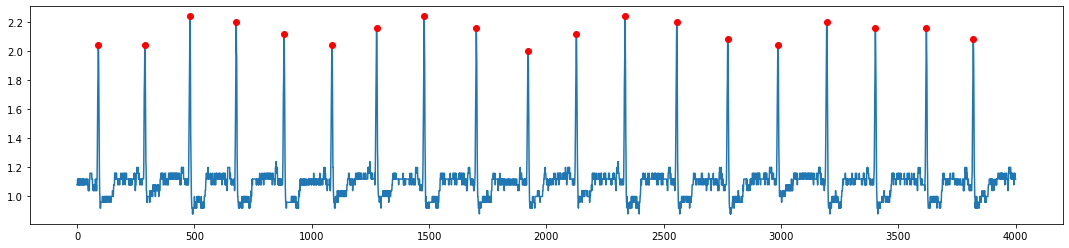

In [380]:
peaks, _ = find_peaks(ecg_ictal[:4000], distance=180)
np.diff(peaks)
plt.plot(ecg_ictal[:4000])
plt.plot(peaks, ecg_ictal[:4000][peaks], "ro")
fig = plt.gcf()
fig.set_size_inches(18.5, 4)

In [484]:
#fs = 200
#detectors = Detectors(fs)

#r_peaks_pan = detectors.christov_detector(ecg_ictal)
#r_peaks_pan= np.asarray(r_peaks_pan)

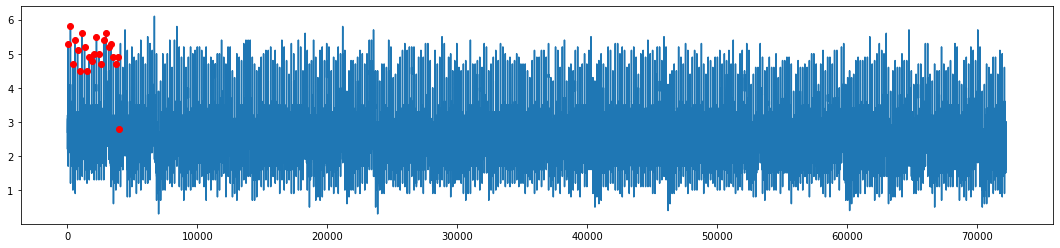

In [485]:
def R_correction(signal, peaks):

    num_peak=peaks.shape[0]
    peaks_corrected_list=list()
    for index in range(num_peak):
        i=peaks[index]
        cnt=i
        if cnt-1<0:
            break
        if signal[cnt]<signal[cnt-1]:
            while signal[cnt]<signal[cnt-1]:
                cnt-=1
                if cnt<0:
                    break
        elif signal[cnt]<signal[cnt+1]:
            while signal[cnt]<signal[cnt+1]:
                cnt+=1
                if cnt<0:
                    break
        peaks_corrected_list.append(cnt)
    peaks_corrected=np.asarray(peaks_corrected_list)            
    return peaks_corrected

corrected_R_peak=R_correction(ecg_ictal,peaks)
plt.plot(ecg_ictal)
plt.plot(corrected_R_peak,ecg_ictal[corrected_R_peak], 'ro')
fig = plt.gcf()
fig.set_size_inches(18.5, 4)